<a href="https://colab.research.google.com/github/dookda/499-64/blob/main/testLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

# path monthly car sale.csv from githubusercontent.com/jbrownlee/Datasets/master
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv', header=0)
df.head()



,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


(108, 1)
86


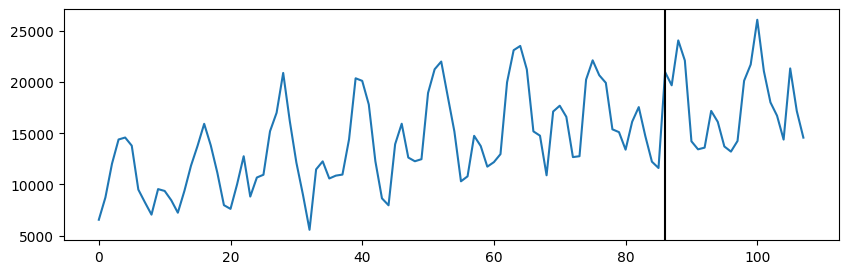

In [22]:
# use column sales
df = df[['Sales']]
df.head()

df.isnull().sum()
print(df.shape)

n_train = int(df.shape[0] * 0.8)
print(n_train)

plt.figure(figsize=(10, 3))
plt.plot(df)
# df.plot()
plt.axvline(x=n_train,c='k')
plt.show()

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(df)

def convertToMatrix(data, step=1):
  X, Y = [], []
  for i in range(len(data)-step):
    x, y = data[i:i+step], data[i+step]
    X.append(x)
    Y.append(y)
  return np.array(X), np.array(Y)

train, test = data_sc[:n_train], data_sc[n_train:]

step = 1
X_train, y_train = convertToMatrix(train, step)
X_test, y_test = convertToMatrix(test, step)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(85, 1, 1) (85, 1)
(21, 1, 1) (21, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

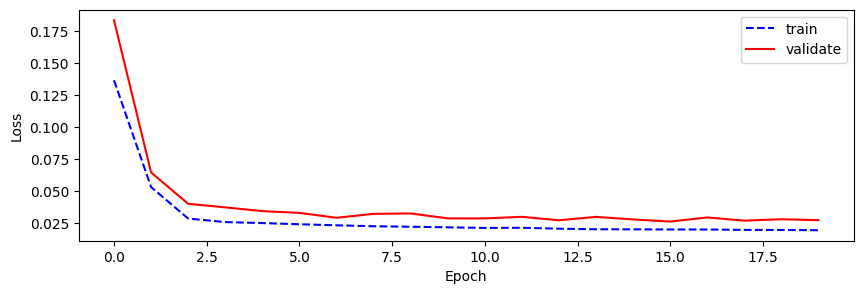

In [55]:
model = Sequential()
model.add(LSTM(units=32,
               input_shape=(step, 1),
               activation='relu', #'tanh'
               recurrent_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=1,
    validation_data=(X_test, y_test),
    verbose=0)

plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'], 'b--', label='train',)
plt.plot(history.history['val_loss'], 'r-' ,label='validate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
train_predict_inv = scaler.inverse_transform(train_predict)
test_predict_inv = scaler.inverse_transform(test_predict)

# print(train_predict_inv)

y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

r2_train = r2_score(y_train_inv, train_predict_inv)
r2_test = r2_score(y_test_inv, test_predict_inv)

rmse_train = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

print(f'R2 train: {r2_train}')
print(f'R2 test: {r2_test}')
print(f'RMSE train: {rmse_train}')
print(f'RMSE test: {rmse_test}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
R2 train: 0.5462296999938268
R2 test: 0.1933094001521477
RMSE train: 0.13896734641076744
RMSE test: 0.16574070411514655


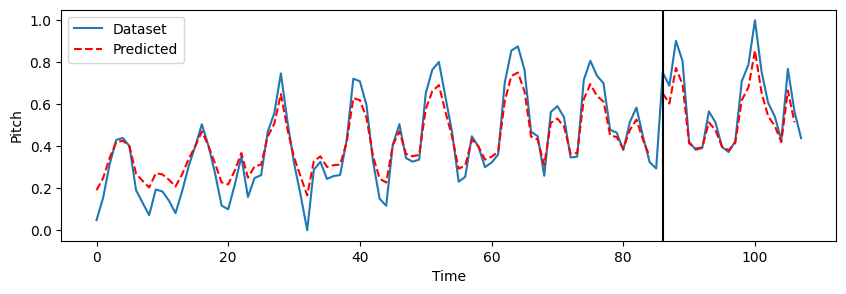

In [57]:
prefix = np.empty(step).reshape(-1, 1)
prefix.fill(np.nan)
# train_predict_inv = np.append(prefix, train_predict_inv, axis=0)
test_predict_inv = np.append(prefix, test_predict_inv, axis=0)

predicted = np.concatenate((train_predict_inv, test_predict_inv), axis=0)
# print(predicted)

plt.figure(figsize=(10, 3))
plt.plot(df, label='Dataset')
plt.plot(predicted, 'r--', label='Predicted')
plt.axvline(x=n_train, color='k', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.legend()
plt.show()